In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()

from matplotlib.pyplot import rc_context

Memory usage: current 0.21 GB, difference +0.21 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *
from db_dev.plotting import *

In [4]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [5]:
#load data with leiden
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [6]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]

# Perform a left join
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")

# Update the adata.obs with the new annotations
adata.obs = updated_obs


In [9]:
aml_cells = [
"AML cells 1",
"AML cells 2",
"AML cells 3",
"AML cells 4",
"AML cells 5",
"AML cells 6",
"AML cells 7",
"AML cells 8",
"AML cells 9",
"AML cells 10",
"AML Monocytes 1",
"AML Monocytes 2"
]

In [15]:
# Z-scale and subset 
adata.layers["scaled"] = sc.pp.scale(adata, max_value = 10, copy = True).X

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name = "cmap", 
    colors=[#"#D3D3D3", #grey
            "white",
            #'#ff8080', 
            "#c96a6a"
            #"#cc0000" #dark-red
           ])

In [17]:
adata_aml = adata[(adata.obs["sample"] == "UL") & (adata.obs["cell_type_sub_prolif_anno"].isin(aml_cells))].copy()

/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [18]:
# Mapping for new column "program"
programs = ["HSC/Prog-like", "GMP-like", "Myeloid-like"]

program_mapping = {
    "AML cells 1": "HSC/Prog-like",
    "AML cells 2": "HSC/Prog-like",
    "AML cells 5": "HSC/Prog-like",
    "AML cells 8": "HSC/Prog-like",
    "AML cells 9": "HSC/Prog-like",
    "AML cells 6": "HSC/Prog-like",
    "AML cells 10": "HSC/Prog-like",
    "AML cells 4": "GMP-like",
    "AML cells 7": "GMP-like",
    "AML cells 3": "HSC/Prog-like",
    "AML Monocytes 2": "Myeloid-like",
    "AML Monocytes 1": "Myeloid-like",
    "Cycling AML cells 1": "GMP-like",
    "Cycling AML cells 2": "GMP-like",
    "Cycling AML Monocytes": "Myeloid-like"
    
}

# Assign new column based on mapping
adata_aml.obs["phenotype"] = adata_aml.obs["cell_type_sub_prolif_anno"].map(program_mapping)



In [16]:
#find non abund genes
E = sc.pp.normalize_per_cell(adata_aml.layers["counts"], counts_per_cell_after = 1e4, copy = True)
######min_cells = 5, min_counts = 10######
# Filtering "noisy" genes
gmask = filter_abund_genes(E = E, min_cells = 5, min_counts = 10)

print(len(adata_aml[:, gmask].var_names))
print(len(adata_aml.var_names))
abund_genes = list(adata_aml[:, gmask].var_names)



12372 genes passing abundance filter
12372
37733


In [17]:
print(len(adata_aml))
adata_aml = adata_aml[:, gmask]
print(len(adata_aml))

13216
13216


ranking genes


/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished (0:00:16)


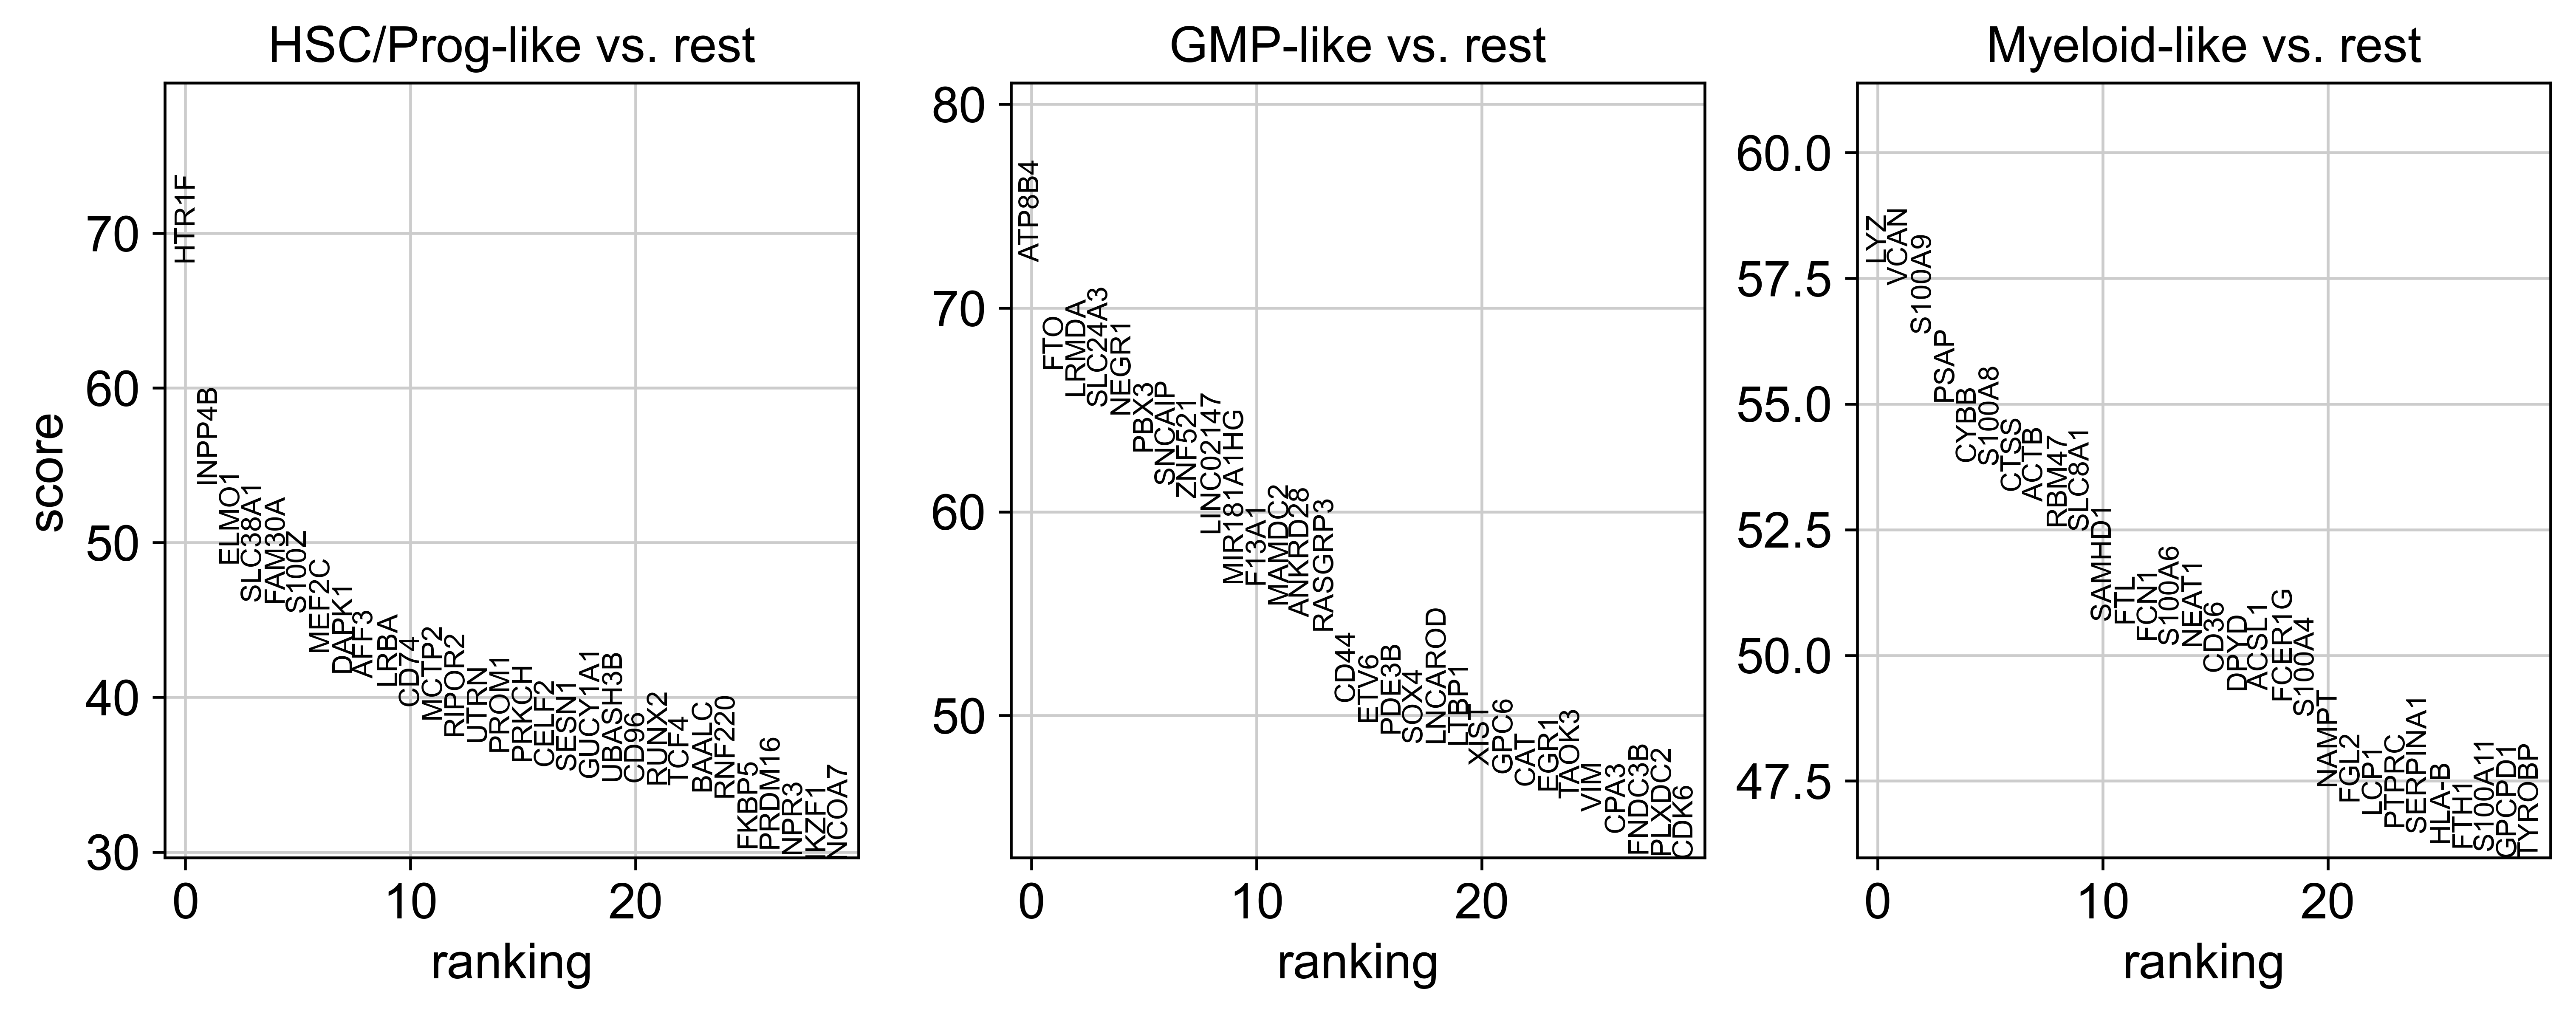

In [18]:
# DGE only on subseted AML cells (phenotypes)
sc.tl.rank_genes_groups(adata_aml, "phenotype", groups=programs, reference = "rest", method = "wilcoxon", use_raw = False)
sc.pl.rank_genes_groups(adata_aml, n_genes = 30, sharey = False)

In [20]:
rank_genes_groups = adata_aml.uns['rank_genes_groups']
# Save the dictionary to a file
filename = "backups/aml_phenotype_rank_genes_groups_final_annotation_%s.pkl"%(now())

with open(filename, "wb") as f:
    pickle.dump(rank_genes_groups, f)

In [20]:
# > FC 1 ; p <0.05

gene_names = pd.DataFrame(rank_genes_groups["names"])
fold_changes = pd.DataFrame(rank_genes_groups["logfoldchanges"])
pvals_adj = pd.DataFrame(rank_genes_groups["pvals_adj"])

sorted_filtered_dge_by_fc = pd.DataFrame()

for cell_type in gene_names.columns:
    temp_df = pd.DataFrame({
        "Gene": gene_names[cell_type],
        "LogFoldChange": fold_changes[cell_type],
        "PvalAdj": pvals_adj[cell_type]
    })
    temp_df = temp_df[temp_df["PvalAdj"] < 0.05]

    temp_df = temp_df[temp_df["LogFoldChange"] > 1]
    
    temp_df = temp_df.sort_values(by="LogFoldChange", ascending=False, key=abs).reset_index(drop=True)

    sorted_filtered_dge_by_fc[cell_type] = temp_df["Gene"]

dge_aml_sorted_by_fc_and_p = sorted_filtered_dge_by_fc.copy()

In [30]:
dge_aml_sorted_by_fc_and_p.head(100).to_excel("dge/final/top100_dge_aml_phenotypes_sorted_by_FC_and_p_only_abund_5cells_10counts.xlsx")
dge_aml_sorted_by_fc_and_p.head(200).to_excel("dge/final/top200_dge_aml_phenotypes_sorted_by_FC_and_p_only_abund_5cells_10counts.xlsx")
dge_aml_sorted_by_fc_and_p.to_excel("dge/final/all_genes_dge_aml_phenotypes_sorted_by_FC_and_p_only_abund_5cells_10counts.xlsx")

In [18]:
dge_aml_sorted_by_fc_and_p.head(20)

,HSC/Prog-like,GMP-like,Myeloid-like
0,SCN3A,NEGR1,VCAN
1,LINC00355,TTC29,MKX
2,CRHBP,SNCAIP,FN1
3,HTR1F,PTPN14,MAFB
4,ENSG00000287616,MPO,SDC2
5,SPRY1,GPC6,LGALS3
6,ENSG00000286123,CLDN10,CD163
7,ENSG00000287352,NEK10,ADAMTS2
8,BTLA,SLC7A2,AMPH
9,SOCS2-AS1,F13A1,ENSG00000253821


In [24]:
def yticks_fancy(a,totick,labels_all, color_dict,emptychar = '',fontsize=5, leftshift=0):
    
    """
    utility function originally made for ticking only a subset of selected genes in a genes x observations heatmap.
    example of use: yticks_fancy(a,['Csf1r','Ccr2','','','Arg1','S100a9'],genes_by_cells.index)
    input:
        a - axis with heatmap
        totick - list of yticklabels to display. Use the string defined by
        emptychar to add spacing between groups of genes.
        labels_all - all yticklabels.
        emptychar - string that will be treated as white space
        
    returns: nothing
    
    """


    a.set_yticks([])
    #leftshift = 0
    totick = np.array(totick)
    nr_slots = len(totick)
    tickmask = np.array([i!=emptychar for i in totick])
    totick = totick[tickmask]
    y_right = np.array([pd.Index(labels_all).get_loc(i) for i in totick])
    
    tickorder = np.argsort(y_right)
    y_right = y_right[tickorder]
    totick = totick[tickorder]
    y_left = np.linspace(0,len(labels_all),nr_slots)[tickmask]
    for l,r,gene in zip(y_left,y_right,totick):
        a.plot((-200+leftshift, -1-leftshift), (r,r), lw=0.5,color='0.2', clip_on=False)
        a.plot((-200-leftshift, -1-leftshift), (l,r), lw=0.5,color='0.2', clip_on=False)
        
        a.text(-1-(leftshift*2),l ,gene,ha='right',va='center',fontsize=fontsize, color = color_dict[gene], clip_on=False)



/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_5797/2220731625.py:216: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


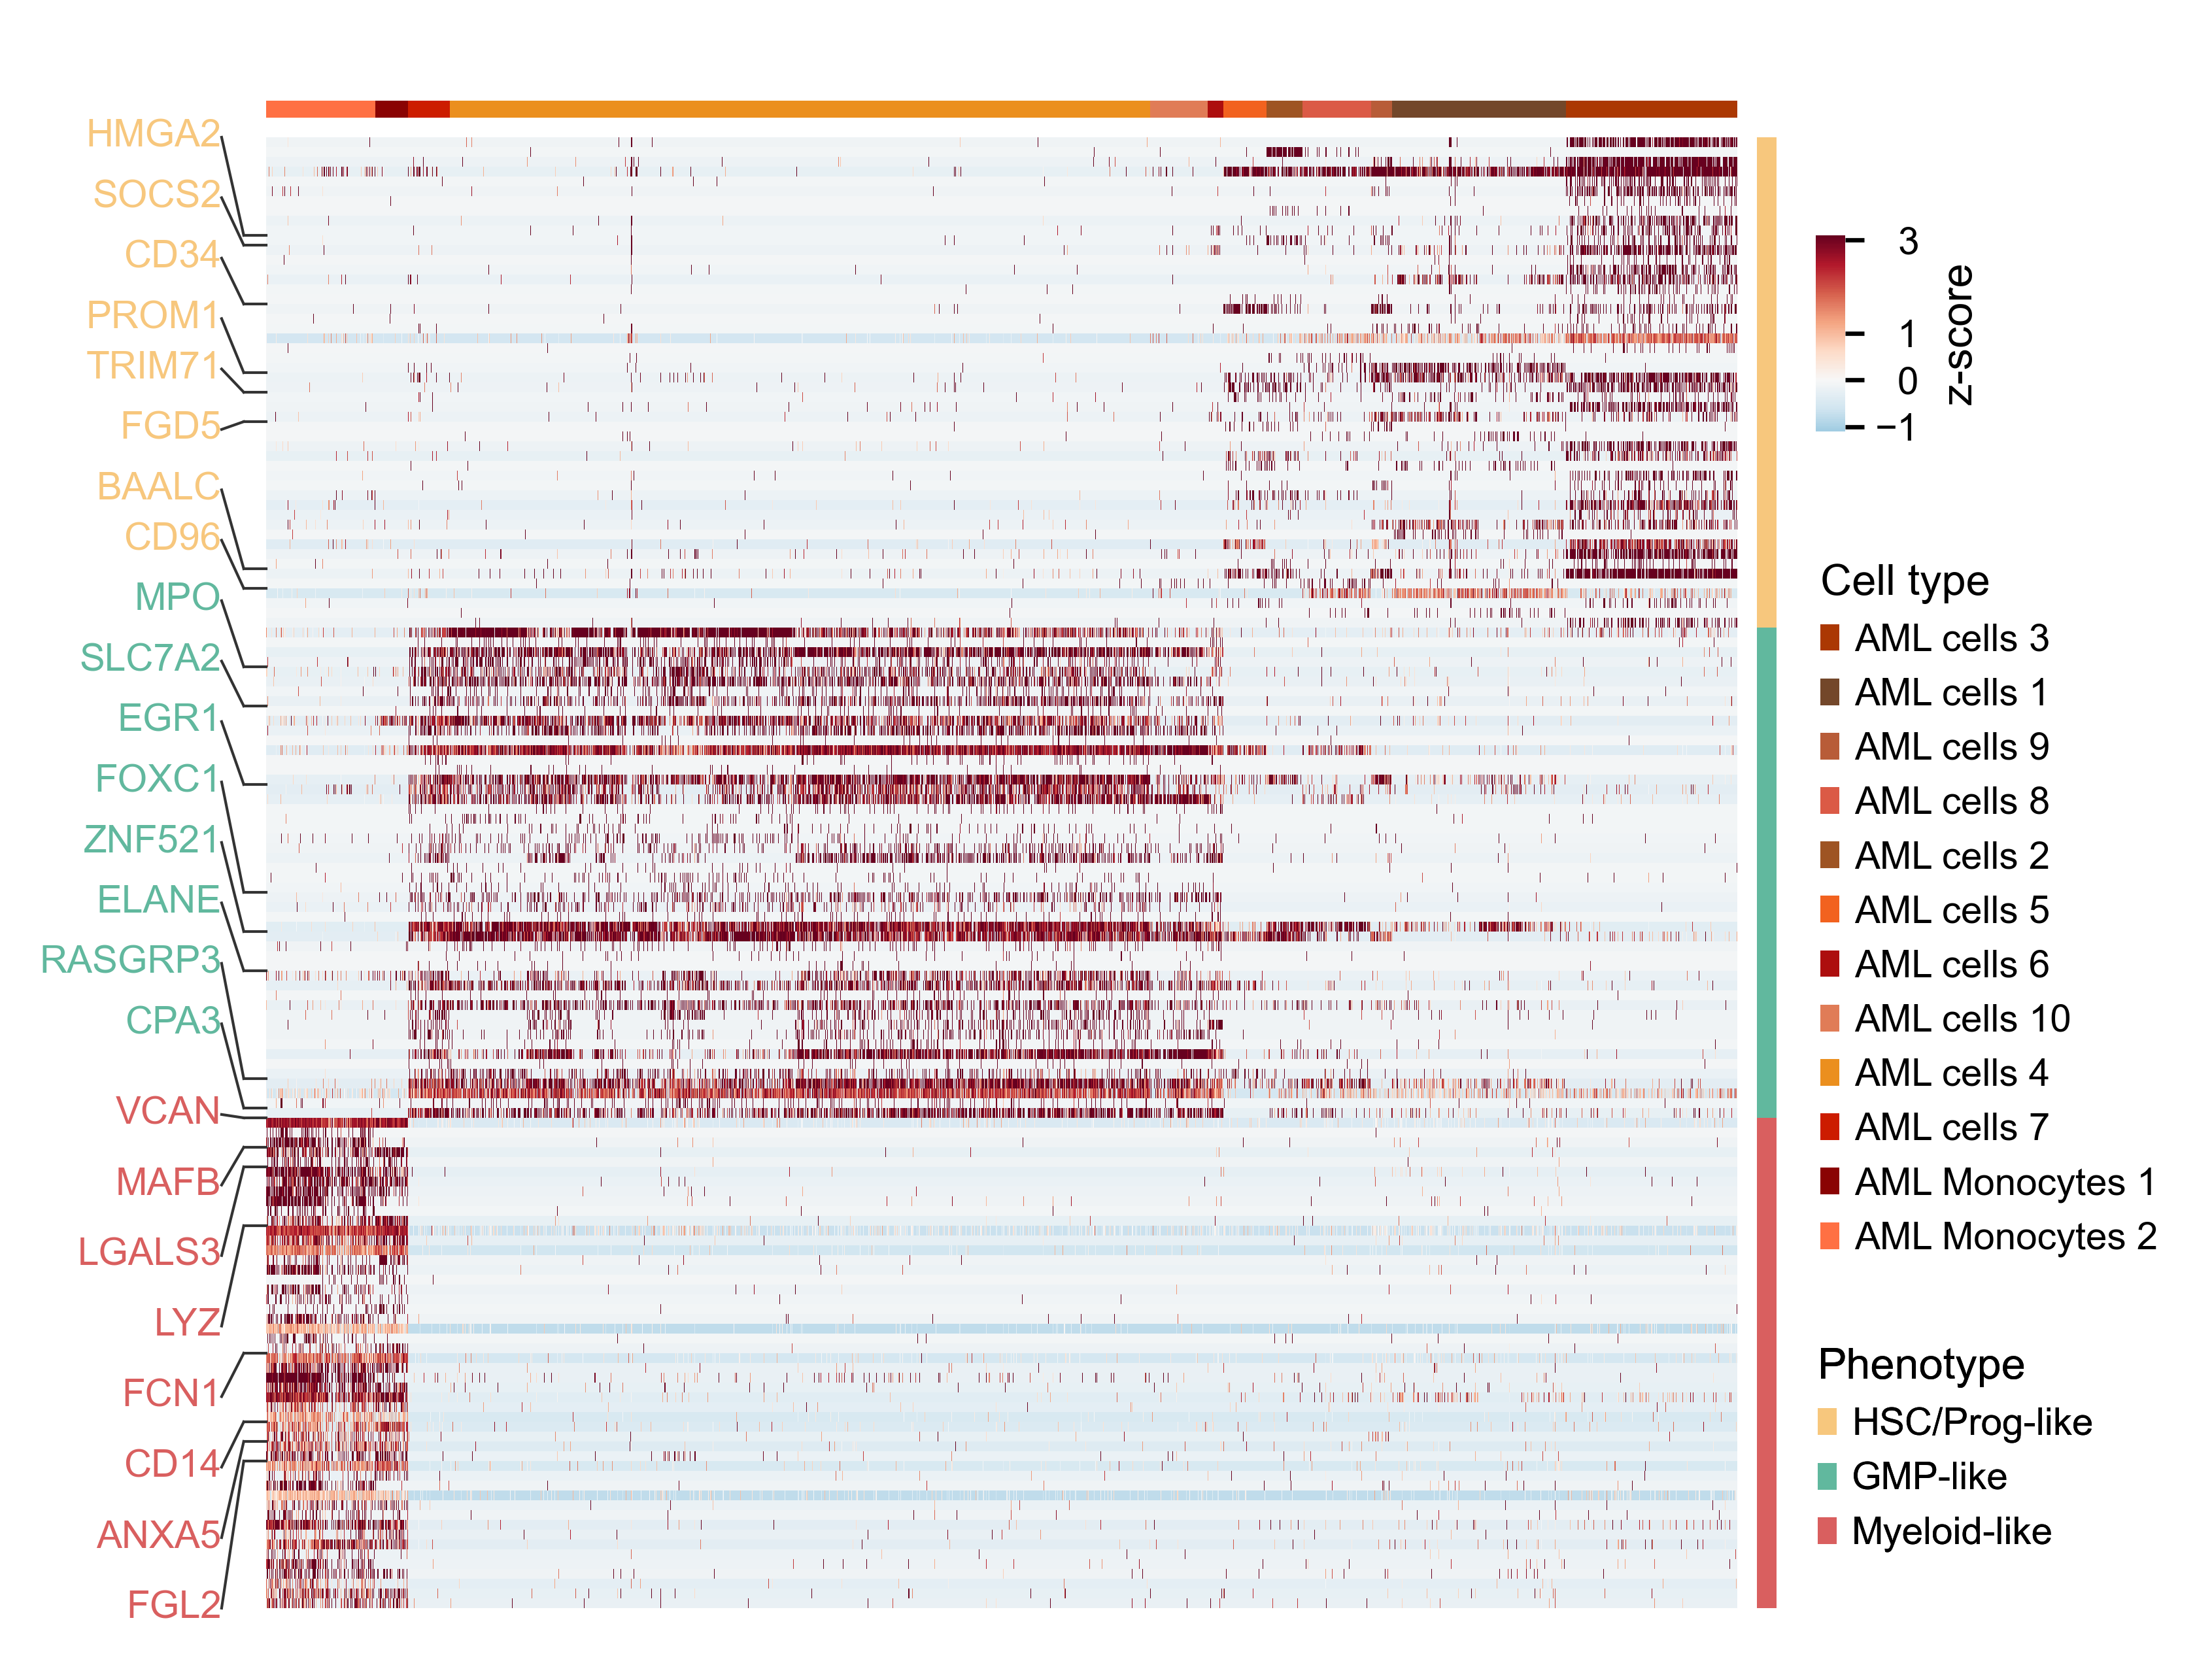

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


HSC_Prog_like = list(dge_aml_sorted_by_fc_and_p["HSC/Prog-like"])[0:50]
GMP_like = list(dge_aml_sorted_by_fc_and_p["GMP-like"])[0:50]
Myeloid_like =list(dge_aml_sorted_by_fc_and_p["Myeloid-like"])[0:50]

aml_programs_genes_dict = {
    "HSC/Prog-like": HSC_Prog_like,
    "GMP-like": GMP_like,
    "Myeloid-like": Myeloid_like,
}


aml_cells = [
"AML Monocytes 2", #Myeloid-like
"AML Monocytes 1", #Myeloid-like
"AML cells 7", #GMP-like
"AML cells 4", #GMP-like
"AML cells 10", #HSC/Prog-like
"AML cells 6", #HSC/Prog-like
"AML cells 5", #HSC/Prog-like
"AML cells 2", #HSC/Prog-like
"AML cells 8", #HSC/Prog-like
"AML cells 9", #HSC/Prog-like
"AML cells 1", #HSC/Prog-like
"AML cells 3" #HSC/Prog-like
]

all_genes = HSC_Prog_like + GMP_like + Myeloid_like

expression_matrix = adata_aml[:, all_genes].layers["scaled"].toarray()
df_exp = pd.DataFrame(
    expression_matrix,
    index=adata_aml.obs_names,  
    columns=all_genes           
)



df_exp["cluster"] = adata_aml.obs["cell_type_sub_prolif_anno"].values
df_exp["cluster"] = pd.Categorical(df_exp["cluster"], categories=aml_cells, ordered=True)
df_exp_sorted = df_exp.sort_values(by="cluster")

df_numeric = df_exp_sorted.drop(columns=["cluster"]).transpose()

cell_type_color_palette = {
    "AML cells 3": "#ab3803",
    "AML cells 1": "#73472a",
    "AML cells 9": "#b85c38",
    "AML cells 8": "#db5a46",
    "AML cells 2": "#9e5423",
    "AML cells 5": "#f2621f",
    "AML cells 6": "#ad0e0e",
    "AML cells 10": "#e07c57",
    "AML cells 4": "#eb8f1e",
    "AML cells 7": "#cc1c00",
    "AML Monocytes 1": "#8a0303",
    "AML Monocytes 2": "#ff7043"
}


program_color_palette = {
    "HSC/Prog-like": "#f7c77d",      
    "GMP-like": "#61b89e",           
    "Myeloid-like": "#d95f5f",       

}


df_exp_sorted["cluster"] = df_exp_sorted["cluster"].astype(str)
col_colors = df_exp_sorted["cluster"].map(cell_type_color_palette).values


row_colors = [
    program_color_palette["HSC/Prog-like"] if gene in HSC_Prog_like else
    program_color_palette["GMP-like"] if gene in GMP_like else
    program_color_palette["Myeloid-like"] if gene in Myeloid_like else "white"
    for gene in df_numeric.index
]


g = sns.clustermap(
    df_numeric,
    cmap="RdBu_r",           
    center=0,
    robust=True,
    vmin = -1.1,
    vmax = 3.1,
    figsize=(5, 5),
    xticklabels=False,   
    yticklabels=False,  
    row_cluster=False,
    col_cluster=False,
    col_colors=col_colors,
    row_colors=row_colors,
    linewidths=0
)


g.fig.subplots_adjust(left=0.12, right=0.93, top=0.9, bottom=0.1)
g.ax_heatmap.set_position([0.12, 0.1, 0.75, 0.75])
g.ax_col_colors.set_position([0.12, 0.86, 0.75, 0.0085])
g.ax_row_colors.set_position([0.88, 0.1, 0.01, 0.75]) # rows
g.cax.set_position([0.91, 0.7, 0.015, 0.1])
g.cax.grid(False)
g.cax.tick_params(labelsize=7)
g.cax.set_ylabel("z-score", fontsize=8)


custom_ticks = [-1, 0, 1, 3]

g.cax.set_yticks(custom_ticks)


for artist in g.ax_heatmap.get_children():
    if isinstance(artist, plt.matplotlib.collections.QuadMesh):
        artist.set_rasterized(True)
for artist in g.ax_col_colors.get_children():
    artist.set_rasterized(True)
for artist in g.ax_row_colors.get_children():
    artist.set_rasterized(True)


legend_elements_cell_types = [
    Patch(facecolor=color, edgecolor="none", label=cell_type)
    for cell_type, color in cell_type_color_palette.items()
]

legend_elements_programs = [
    Patch(facecolor=color, edgecolor="none", label=program)
    for program, color in program_color_palette.items()
]

cell_type_legend = plt.legend(
    handles=legend_elements_cell_types,
    bbox_to_anchor=(12.8, -0.5),
    ncol=1,
    title="Cell type",
    fontsize=7,
    title_fontsize=8,
    frameon=False
)
cell_type_legend._legend_box.align = "left"

program_legend = plt.legend(
    handles=legend_elements_programs,
    bbox_to_anchor=(10.6, -4.5),
    ncol=1,
    title="Phenotype",
    fontsize=7,
    title_fontsize=8,
    frameon=False
)
program_legend._legend_box.align = "left"

g.fig.add_artist(cell_type_legend)
g.fig.add_artist(program_legend)

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.tight_layout()


color_dict = {}
for gene in df_numeric.index:
    if gene in HSC_Prog_like:
        color_dict[gene] = program_color_palette["HSC/Prog-like"]
    elif gene in GMP_like:
        color_dict[gene] = program_color_palette["GMP-like"]
    elif gene in Myeloid_like:
        color_dict[gene] = program_color_palette["Myeloid-like"]
    else:
        color_dict[gene] = "black"


               
hsc_prog_best = [
    "CD34",   
    "", "", "", "", "", 
    "PROM1",  
    "", "", "", "", "", 
    "SOCS2", 
    "", "", "", "", "",
    "FGD5"
    "", "", "", "", "",
    "TRIM71",
    "", "", "", "", "",
    "BAALC",
    "", "", "", "", "",
    "HMGA2"
    "", "", "", "", "",
    "CD96",
    "", "", "", "", "",

]

gmp_best = [
    "EGR1",
    "", "", "", "", "", 
    "ZNF521", 
    "", "", "", "", "",
    "MPO",    
    "", "", "", "", "", 
    "RASGRP3",
    "", "", "", "", "", 
    "FOXC1",
    "", "", "", "", "", 
    "ELANE",   
    "", "", "", "", "", 
    "SLC7A2",
    "", "", "", "", "", 
    "CPA3", "", "", "",
    "", "", "", "",  "",
]

myeloid_best = [
    "LGALS3",  
    "", "", "", "", "", "",
    "MAFB",
    "", "", "", "", "", "", 
    "CD14",    
    "", "", "", "", "", "", 
    "FGL2", 
    "", "", "", "", "", "",
    "LYZ",  
    "", "", "", "", "", "",
    "FCN1", 
    "", "", "", "", "", "",
    "ANXA5", 
    "", "", "", "", "", "",
    "VCAN"
]

genes_to_label = hsc_prog_best + gmp_best + myeloid_best

ax = g.ax_heatmap
yticks_fancy(
    a=ax,
    totick=genes_to_label,
    labels_all=df_numeric.index,
    color_dict=color_dict,
    emptychar='', 
    fontsize=7, leftshift=200
)


plt.setp(g.cax.get_yticklabels(), ha="right")
g.cax.tick_params(axis="y", pad=10)


plt.savefig("figures/final/aml_blasts_phenotype_heatmap_zscore_v3.pdf", transparent=True, bbox_inches="tight", dpi=300)
plt.savefig("figures/final/aml_blasts_phenotype_heatmap_zscore_v3.svg", transparent=True, bbox_inches="tight", dpi=300)
plt.show()
